In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000  # in meters
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    i_left = 0
    i_right = 0
    j_down = 0
    j_up = 0
    while (i_search - i_left >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search - i_left, j_search], lon_rho[i_search - i_left, j_search])) < SEARCH_WIDTH/2:
        i_left += 1
    while (i_search + i_right < lon_rho.shape[0] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search + i_right, j_search], lon_rho[i_search + i_right, j_search])) < SEARCH_WIDTH/2:
        i_right += 1
    while (j_search - j_down >= 0 and 
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search], 
                    lat_rho[i_search, j_search - j_down], lon_rho[i_search, j_search - j_down])) < SEARCH_WIDTH/2:
        j_down += 1
    while (j_search + j_up < lon_rho.shape[1] and
           distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                    lat_rho[i_search, j_search + j_up], lon_rho[i_search, j_search + j_up])) < SEARCH_WIDTH/2:
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_up = min(j_search + j_up, lon_rho.shape[1])
    j_down = max(j_search - j_down + 1, 0)

    return i_left, i_right, j_down, j_up

edata = eddies['Eddy277'].iloc[15]
t = extract_number(edata.name)

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:

    CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy') - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    previous_file_idx = file_idx

## MC METHOD

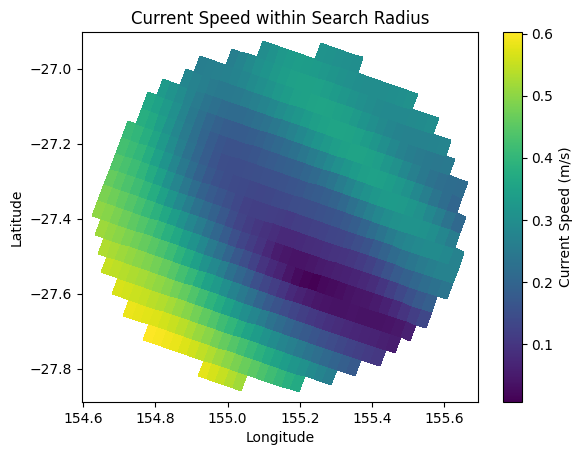

In [4]:
surf_lon = edata.Lon
surf_lat = edata.Lat
R = distance(edata.Lat, edata.Lon, lat_rho, lon_rho)
mask = R < 50000 #m
CurSpeed_masked = np.where(mask, CurSpeed[:,:,15, t_mod], np.nan) 
plt.pcolormesh(lon_rho, lat_rho, CurSpeed_masked)
plt.colorbar(label='Current Speed (m/s)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Current Speed within Search Radius')
plt.xlim([np.nanmin(np.where(mask,lon_rho,np.nan))-0.05,np.nanmax(np.where(mask,lon_rho,np.nan))+0.05])
plt.ylim([np.nanmin(np.where(mask,lat_rho,np.nan))-0.05,np.nanmax(np.where(mask,lat_rho,np.nan))+0.05])
plt.show()

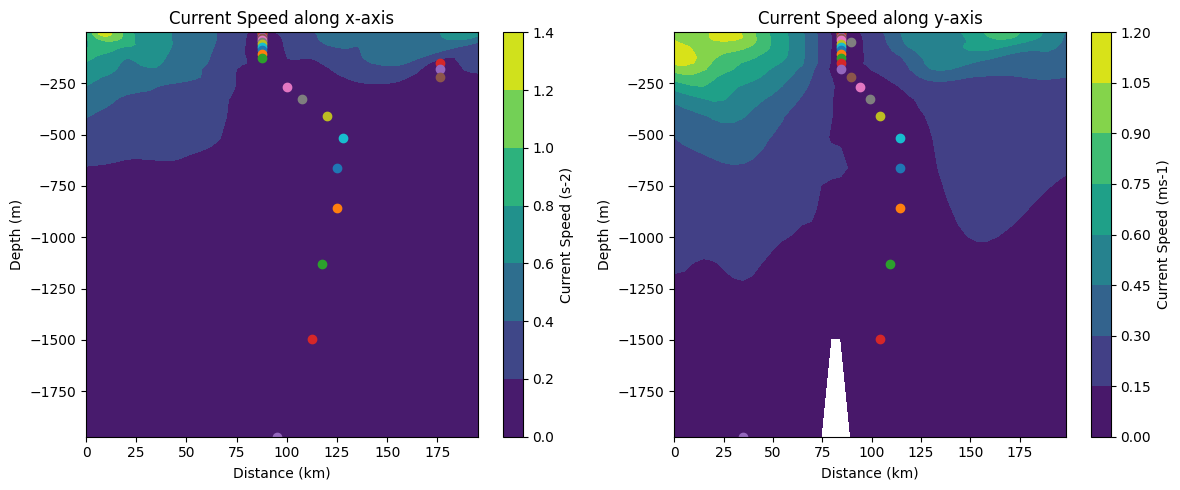

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

SEARCH_WIDTH = 200000
depth_lvl_limit = 25

# First subplot
i_left, i_right, _, _ = grid_finder(i_search, j_search, SEARCH_WIDTH)

CurSpeed_cross = CurSpeed[i_left:i_right, j_search, :depth_lvl_limit, t_mod] 
x = distance(lat_rho[i_left, j_search], lon_rho[i_left, j_search], lat_rho[i_left:i_right, j_search], lon_rho[i_left:i_right, j_search])/1000
z = z_r[150, 150, :depth_lvl_limit]

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, CurSpeed_cross.T)
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('Current Speed along x-axis')
fig.colorbar(c1, ax=axs[0], label='Current Speed (s-2)')

max_indices = np.nanargmin(CurSpeed_cross, axis=0)
for r, max_index in enumerate(max_indices):
    axs[0].scatter(x[max_index], z[r])

# Second subplot
_, _, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)

CurSpeed_cross = CurSpeed[i_search, j_down:j_up, :depth_lvl_limit, t_mod] 
y = distance(lat_rho[i_search, j_down], lon_rho[i_search, j_down], lat_rho[i_search, j_down:j_up], lon_rho[i_search, j_down:j_up])/1000
z = z_r[150, 150, :depth_lvl_limit]

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, CurSpeed_cross.T)
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('Current Speed along y-axis')
fig.colorbar(c2, ax=axs[1], label='Current Speed (ms-1)')

min_indices = np.nanargmin(CurSpeed_cross, axis=0)
for r, min_index in enumerate(min_indices):
    axs[1].scatter(y[min_index], z[r])

plt.tight_layout()
plt.show()

In [6]:
SEARCH_RADIUS = 50000
surf_lon = edata.Lon
surf_lat = edata.Lat

depth_dics = {}

for depth_lvl in range(25):
    if depth_lvl == 0:
        R = np.sqrt((lon_rho - surf_lon)**2 + (lat_rho - surf_lat)**2)
    else:
        R = np.sqrt((lon_rho - c_lon)**2 + (lat_rho - c_lat)**2)

    i_search_lvl, j_search_lvl = np.argwhere(R == np.min(R))[0]
    
    R = distance(lat_rho[i_search_lvl, j_search_lvl], lon_rho[i_search_lvl, j_search_lvl], lat_rho, lon_rho)
    mask = R < SEARCH_RADIUS
    
    CurSpeed_masked = np.where(mask, CurSpeed[:,:,depth_lvl, t_mod], np.nan) 
    if np.any(np.isfinite(CurSpeed_masked)):
        ic, jc = np.unravel_index(np.nanargmin(CurSpeed_masked), CurSpeed_masked.shape)
        ic, jc = int(ic), int(jc)
    
        ix, jy = np.where(mask == True)
        df = pd.DataFrame({
            'i': ix,
            'j': jy,
            'CS': CurSpeed_masked[ix,jy]
        })
    
        depth = float(z_r[150,150,depth_lvl])
    
        depth_dics['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'Depth': depth}
    
        c_lon = lon_rho[ic, jc]
        c_lat = lat_rho[ic, jc]

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

theta0 = np.deg2rad(edata.Lon)
phi0 = np.deg2rad(edata.Lat)

for depth_dic in depth_dics:
    
    ix = depth_dics[depth_dic]['df'].i
    jy = depth_dics[depth_dic]['df'].j
    ic = depth_dics[depth_dic]['ic']
    jc = depth_dics[depth_dic]['jc']
    
    lons = lon_rho[ix, jy]
    lats = lat_rho[ix, jy]
    lonc = lon_rho[ic, jc]
    latc = lat_rho[ic, jc]
    
    lonr = np.deg2rad(lons)
    latr = np.deg2rad(lats)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    
    xc = r_earth * np.cos(phi0) * (np.deg2rad(lonc) - theta0)
    yc = r_earth * (np.deg2rad(latc) - phi0)

    depth_dics[depth_dic]['df']['x'] = x
    depth_dics[depth_dic]['df']['y'] = y
    depth_dics[depth_dic]['xc'] = float(xc)
    depth_dics[depth_dic]['yc'] = float(yc)

/scratch/pbs.5629914.kman.restech.unsw.edu.au/ipykernel_2471519/2165335850.py:20: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='CS')


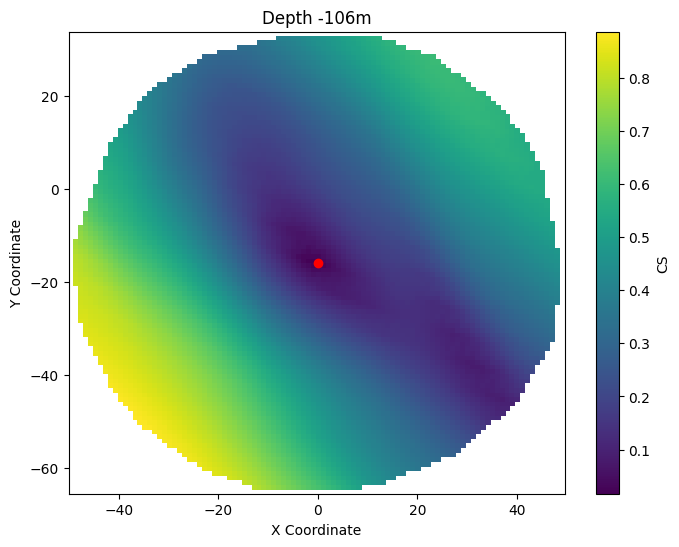

In [7]:
from scipy.interpolate import griddata

depth_dic = 'Depth11'

CS = depth_dics[depth_dic]['df']['CS']

x = depth_dics[depth_dic]['df'].x
y = depth_dics[depth_dic]['df'].y

xc = depth_dics[depth_dic]['xc']
yc = depth_dics[depth_dic]['yc']

d = depth_dics[depth_dic]['Depth']

X, Y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
Z = griddata((x, y), CS, (X, Y), method='linear')

plt.figure(figsize=(8, 6)) 
plt.pcolor(X, Y, Z, cmap='viridis', shading='auto')
plt.colorbar(label='CS')
plt.scatter(xc, yc, marker='o', color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Depth '+str(round(d))+'m')
plt.show()

In [8]:
def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x, y

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

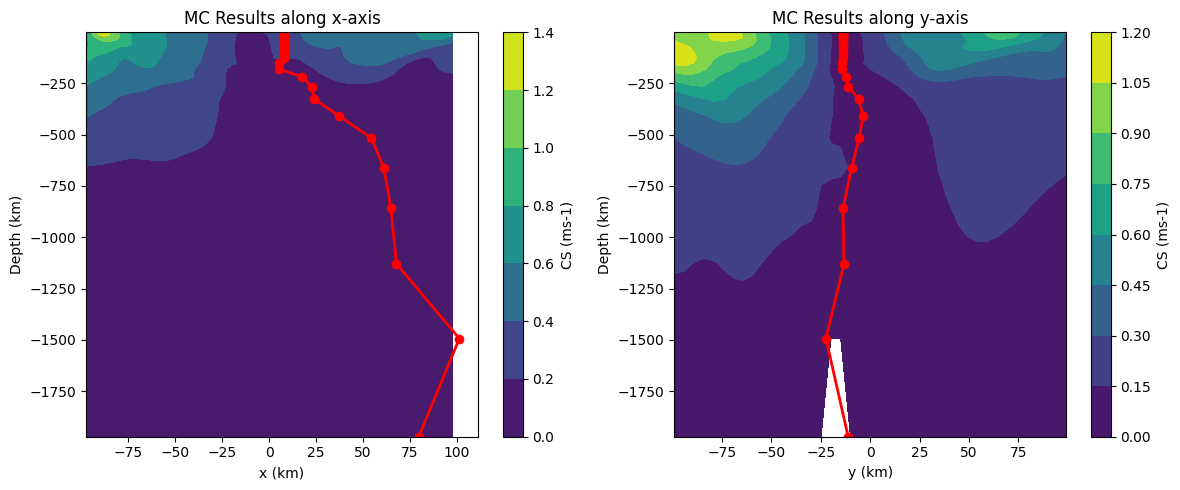

In [9]:
import matplotlib.colors as mcolors

R = np.sqrt((lon_rho - edata.Lon)**2 + (lat_rho - edata.Lat)**2)
i_search, j_search = np.argwhere(R == np.min(R))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

DISPLAY_WIDTH = 200000
depth_lvl_limit = 25

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)

x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

x = x/1000
y = y/1000

xc_raw = []
yc_raw = []
zc = []
for depth_dic in depth_dics:
    xc_raw.append(depth_dics[depth_dic]['xc'])
    yc_raw.append(depth_dics[depth_dic]['yc'])
    zc.append(depth_dics[depth_dic]['Depth'])

xc, yc = rotate_30_clockwise(xc_raw, yc_raw)

z = z_r[150, 150, :depth_lvl_limit]

# First subplot
CurSpeed_cross = CurSpeed[i_left:i_right, j_search, :depth_lvl_limit, t_mod]

X, Z = np.meshgrid(x, z)

c1 = axs[0].contourf(X, Z, CurSpeed_cross.T)
axs[0].contour(X, Z, CurSpeed_cross.T, levels=[0], colors='k')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].set_title('MC Results along x-axis')
fig.colorbar(c1, ax=axs[0], label='CS (ms-1)')

axs[0].scatter(xc, zc, color='red')
axs[0].plot(xc, zc, color='red', linewidth=2)

# Second subplot
CurSpeed_cross = CurSpeed[i_search, j_down:j_up, :depth_lvl_limit, t_mod]

Y, Z = np.meshgrid(y, z)

c2 = axs[1].contourf(Y, Z, CurSpeed_cross.T)
axs[1].contour(Y, Z, CurSpeed_cross.T, levels=[0], colors='k')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('MC Results along y-axis')
fig.colorbar(c2, ax=axs[1], label='CS (ms-1)')

axs[1].scatter(yc, zc, color='red')
axs[1].plot(yc, zc, color='red', linewidth=2)

plt.tight_layout()
plt.show()
